<h1 align="center"> Market Prediction based on News Headlines <h1>


<h2 align='right'> Euiyoung Chung <h2>
## Data Descriptions:

There are two channels of data provided in this dataset:

News data: I crawled historical news headlines from Reddit WorldNews Channel. They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date. (Range: 2008-06-08 to 2016-07-01)

Stock data: Dow Jones Industrial Average (DJIA) is used to "prove the concept". (Range: 2008-08-08 to 2016-07-01)

## Objectives:

The objective of this notebook is to build a binary classifier that returns 0 (down) or 1 (up). Specifically, 1 means an increase in Adj Close value and 0 means a decrease. Given a set of text data, i.e. news headlines, I will apply natural language processing to extract features. The final performance is 

## Table of Contents:

1. **Introduction** <br>
a) Data Import <br>
b) Data Cleaning<br><br>

2. **Feature Engineering**<br>
a) Counter Vectorization<br>
b) TF-IDF Vectorization<br>
c) Feature Selection<br><br>

3. **Predictive Modeling**  
a) Binary Classification<br>
b) Multi-class Classification<br><br>

4. **Evaluation**

<br>
<br>
# 1. Introduction

## Data Import

In [432]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Iteration
import tqdm

# Text Feature Engineering
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.svm import LinearSVC
from sklearn.tree import tree
from sklearn.feature_selection import chi2, SelectFromModel, SelectKBest
from sklearn.base import clone
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression

from collections import Counter

plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
news = pd.read_csv("RedditNews.csv", parse_dates=['Date'])
stock = pd.read_csv("DJIA_table.csv", parse_dates=['Date'])

print("news data shape: ", news.shape)
print("stock data shape: ", stock.shape)

news data shape:  (73608, 2)
stock data shape:  (1989, 7)


In [5]:
news.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [6]:
stock.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [7]:
print("news range:  {} ~ {}".format(news['Date'].dt.date.min(), news['Date'].dt.date.max()))
print("stock range: {} ~ {}".format(stock['Date'].dt.date.min(), stock['Date'].dt.date.max()))

news range:  2008-06-08 ~ 2016-07-01
stock range: 2008-08-08 ~ 2016-07-01


In [9]:
def isSubSet(date1, date2):
    for date in date1['Date'].dt.date.unique():
        unique_date = set(date2['Date'].dt.date.unique())
        how_many_missing = 0

        if date not in unique_date:
            how_many_missing += 1
            
    return how_many_missing
        
print("There are {} dates for stock data when no news headline exists".format(isSubSet(stock, news)))
print("There are {} dates for news data when no stock price exists".format(isSubSet(news, stock)))

There are 0 dates for stock data when no news headline exists
There are 1 dates for news data when no stock price exists


These datasets have two different natures. First, it is a time series data with numeric values. Predictive models will be constructed to forecast the numeric values, i.e. stock prices. Second, the data contains extremely unorganized text data points. Again, the news headlines are listed over time. I will first clean up the text data for further analysis. 

<br>
<br>
## Data Cleaning

**Approaches**
- Drop redundant columns and create a new feature. 
- 'up_or_down' will be a binary label.
- 'up_neutral_down' will be a multi-class label. Those observations with insignificant difference from the previous price will be labeled as neutral.

In [50]:
relative_diff = (stock['Adj Close'].diff()/stock['Volume']).fillna(0)

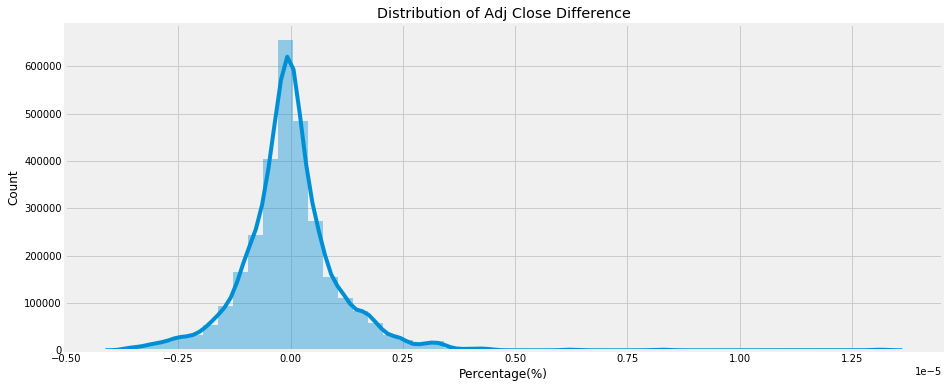

In [51]:
plt.figure(figsize=(14,6))
sns.distplot(relative_diff)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.title("Distribution of Adj Close Difference")
plt.ylabel('Count')
plt.xlabel('Percentage(%)')
plt.show()

In [120]:
# within 1 std from mean is insignificant
mean = relative_diff.mean()
std = relative_diff.std()
insignificant_diff = relative_diff.between(mean-std, mean+std)

print(insignificant_diff.value_counts())

True     1541
False     448
dtype: int64


In [463]:
# Sort
stock.sort_values(by='Date', axis=0, inplace=True)

# Binary labels
stock['up_or_down'] = (stock['Adj Close'].diff() > 0).astype('int')

# Multiple labels
stock['up_neutral_down'] = 1 # neutral
stock['up_neutral_down'][relative_diff>relative_diff.std()] = 2 # up
stock['up_neutral_down'][relative_diff<-relative_diff.std()] = 0 # down

# Drop the first row where no previous date exists
stock.drop(0, axis=0, inplace=True)
stock.reset_index(inplace=True)

stock.head(3)

,level_0,index,Date,Open,High,Low,Close,Volume,Adj Close,up_neutral_down,up_or_down
0,1,1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1,1
1,2,1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0,0
2,3,1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0,0


### News Headlines

News headlines are messy. The lengths are different for each data point. Some dates have a more or less number of headlines than the majority of the others. I will consider all the aspects!

In [464]:
# Group by date
by_date = news.groupby(['Date'])

# See some dates have 22, 23, 24 or 50 headlines
print("Number of headlines per date:", by_date.size().unique())
print("\n", by_date.size().value_counts())

Number of headlines per date: [25 50 24 22 23]

 25    2931
23       5
24       4
50       2
22       1
dtype: int64


In [465]:
wide_news = []
for name, group in by_date:
    wide_news.append(group['News'].values)

wide_news = pd.DataFrame(wide_news).iloc[:,:25]
wide_news = wide_news.applymap(lambda x: x[1:] if x else '')
wide_news['Date'] = by_date.groups

In [466]:
wide_news.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Date
0,'Nim Chimpsky: The tragedy of the chimp who th...,"""Canada: Beware slippery slope' to censorship,...",'EU Vice-President Luisa Morgantini and the Ir...,"""Israeli minister: Israel will attack Iran if ...",'Albino Killings in Tanzania. At least 19 albi...,'Chiapas: army occupies Zapatista communities ...,"'Polar bear swims 200 miles, is shot dead upon...","'News is a contraband item in Pakistan now, an...","'Albinos, Long Shunned, Face Threat in Tanzani...",'Town in Britain Plans to Start its Own Currency','BBC reporter among 16 dead in Afghanistan','Lebanese women still vulnerable to violence: ...,'Police release chilling images of man left fo...,"""Iceland opens Europe's largest national park....",'Citizens fighting Blackwater Potrero. Was the...,"""S. Korean protesters, police clash in beef ra...","""Oil reserves 'will last decades' - a BBC Scot...",'Cameras designed to detect terrorist facial e...,'Israeli peace activists protest 41 years of o...,"""A 5.1 earthquake hits China's Southern Qingha...",'Man goes berzerk in Akihabara and stabs every...,'Threat of world AIDS pandemic among heterosex...,'Angst in Ankara: Turkey Steers into a Dangero...,"""UK: Identity cards 'could be used to spy on p...","'Marriage, they said, was reduced to the statu...",2008-06-08
1,'United States quits Human Rights Council',"""Pentagon blocked Cheney's attack on Iran""","""'J Street,' a new liberal Jewish organization...","'Former Ambassador Joseph Wilson: ""[The U.S. M...",'EU leaders anxiously await Irish verdict on L...,""" 17 Hit or Stabbed, 7 Confirmed Dead in Tokyo...",'Treaty tensions mount as Iraq tells the US it...,"""Council paints over street artist Banksy's gr...","'""Finders keepers"" can get complicated when ha...","'Chew Qat: In Yemen, 72 per cent of men and 32...",'One of UKs most experienced and decorated spe...,'A bitter struggle between two powerful Beltwa...,'Jailers at Guantanamo urged to destroy interr...,'80% UK Laws Now Made In Brussels and the UK P...,'Virgin Media UK working with record industry ...,'35 Ukraine miners trapped underground - threa...,'Bilderberg attendee Geithner calls for global...,"'Jos Manuel Barroso bullies the Irish, saying ...","""Don't worry everyone, AIDS is officially over!""",'What if Bush Attacks Iran on His Way Out of O...,'Future of the United States of Europe in the ...,"""'Military coup' in Zimbabwe as Mugabe is forc...",'Rising Oil Prices Spark Strikes in Spain and ...,"'Chvez to FARC: Asks to end armed strugle, ""Th...",'Fliers in for pain as airlines pack it in',2008-06-09
2,"'Oil shortage a myth, says industry insider'","""Israel launches 'Iran Command' for war""","""Petition Calling for an Investigation into 9/...",'Canadian HRC Tribunal forces pastor to public...,'US and EU threaten to freeze Iranian assets u...,'Thousands of UK homeowners face negative equity','31 year old beats 3 year old to death: worst ...,'White House Saying Senate Doesn\'t Get to Vot...,'Man escapes North Korea after 33 years','The 14-year-old Afghan suicide bomber',"""Zimbabwe 'run by military junta'""",'Former British Prime Minister: Falsely Linkin...,'College Drinking and Heart Problems','What? Tens of Thousands Protest Sale of US Be...,'Bush: U.S. and EU must bond to press Iran on ...,'Shanghai Composite tumbles 7.7 percent ','Olmert Hints That U.S. Attack On Iran Is Near','Is Israel planning on using nukes in its next...,'USS Liberty -- New Revelations in Attack on A...,"""World's first church unearthed in Jordan """,'Corruption in Ukraine allows epidemic to reac...,'Bush Discusses Iran Sanctions With EU Leaders',"""Tibet and the Olympic `tradition'""",'Saddam tribe leader murdered in Iraq','Law creates underclass of child criminals',2008-06-10
3,'BBC uncovers lost Iraq billions','War Criminal George W. Bush not Welcome in th...,"'Offensive Speech: US says it\'s ""free"", other...","'Bush/Cheney Plan Demands 58 US Bases In Iraq,...",

In [467]:
df = stock.merge(wide_news, how='left', on='Date')

In [468]:
# Drop Variables
col_drops = "Open,High,Low,Close,Volume,Adj Close,index".split(",")
df = df.drop(col_drops, axis=1)

In [469]:
df.head()

,level_0,Date,up_neutral_down,up_or_down,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1,2008-08-11,1,1,'Why wont America and Nato help us? If they wo...,'Bush puts foot down on Georgian conflict',"""Jewish Georgian minister: Thanks to Israeli t...",'Georgian army flees in disarray as Russians a...,"""Olympic opening ceremony fireworks 'faked'""",'What were the Mossad with fraudulent New Zeal...,'Russia angered by Israeli military sale to Ge...,'An American citizen living in S.Ossetia blame...,'Welcome To World War IV! Now In High Definiti...,"""Georgia's move, a mistake of monumental propo...",'Russia presses deeper into Georgia; U.S. says...,'Abhinav Bindra wins first ever Individual Oly...,' U.S. ship heads for Arctic to define territory','Drivers in a Jerusalem taxi station threaten ...,'The French Team is Stunned by Phelps and the ...,'Israel and the US behind the Georgian aggress...,"'""Do not believe TV, neither Russian nor Georg...",'Riots are still going on in Montreal (Canada)...,'China to overtake US as largest manufacturer','War in South Ossetia [PICS]','Israeli Physicians Group Condemns State Torture',' Russia has just beaten the United States ove...,'Perhaps *the* question about the Georgia - Ru...,'Russia is so much better at war',"""So this is what it's come to: trading sex for..."
1,2,2008-08-12,0,0,'Remember that adorable 9-year-old who sang at...,"""Russia 'ends Georgia operation'""","'""If we had no sexual harassment we would have...","""Al-Qa'eda is losing support in Iraq because o...",'Ceasefire in Georgia: Putin Outmaneuvers the ...,'Why Microsoft and Intel tried to kill the XO ...,'Stratfor: The Russo-Georgian War and the Bala...,"""I'm Trying to Get a Sense of This Whole Georg...","""The US military was surprised by the timing a...",'U.S. Beats War Drum as Iran Dumps the Dollar',"'Gorbachev: ""Georgian military attacked the So...",'CNN use footage of Tskhinvali ruins to cover ...,'Beginning a war as the Olympics were opening ...,'55 pyramids as large as the Luxor stacked int...,'The 11 Top Party Cities in the World','U.S. troops still in Georgia (did you know th...,'Why Russias response to Georgia was right',"'Gorbachev accuses U.S. of making a ""serious b...","'Russia, Georgia, and NATO: Cold War Two'",'Remember that adorable 62-year-old who led yo...,'War in Georgia: The Israeli connection','All signs point to the US encouraging Georgia...,'Christopher King argues that the US and NATO ...,'America: The New Mexico?',"""BBC NEWS | Asia-Pacific | Extinction 'by man ..."
2,3,2008-08-13,0,0,' U.S. refuses Israel weapons to attack Iran: ...,"""When the president ordered to attack Tskhinva...",' Israel clears troops who killed Reuters came...,'Britain\'s policy of being tough on drugs is ...,'Body of 14 year old found in trunk; Latest (r...,'China has moved 10 *million* quake survivors ...,"""Bush announces Operation Get All Up In Russia...",'Russian forces sink Georgian ships ',"""The commander of a Navy air reconnaissance sq...","""92% of CNN readers: Russia's actions in Georg...",'USA to send fleet into Black Sea to help Geor...,"""US warns against Israeli plan to strike again...","""In an intriguing cyberalliance, two Estonian ...",'The CNN Effect: Georgia Schools Russia in Inf...,'Why Russias response to Georgia was right','Elephants extinct by 2020?','US humanitarian missions soon in Georgia - if...,"""Georgia's DDOS came from US sources""","'Russian convoy heads into Georgia, violating ...",'Israeli defence minister: US against strike o...,'Gorbachev: We Had No Choice','Witness: Russian forces head towards Tbilisi ...,' Quarter of Russians blame U.S. for conflict:...,'Georgian president says US military will tak...,'2006: Nobel laureate Aleksander Solzhenitsyn ...
3,4,2008-08-14,0,1,'All the experts admit that we should legalise...,'War in South Osetia - 89 pictures made by a R...,'Swedish wrestler Ara Abrahamian throws away m...,'Russia exaggerated the death toll in South Os...,

In [471]:
# list of concatenated headlines of each date. 
headlines = df.iloc[:, 3:].apply(''.join ,axis=1)

# Labels    
binary_labels = df['up_or_down'].get_values()
multi_labels = df['up_neutral_down'].get_values()

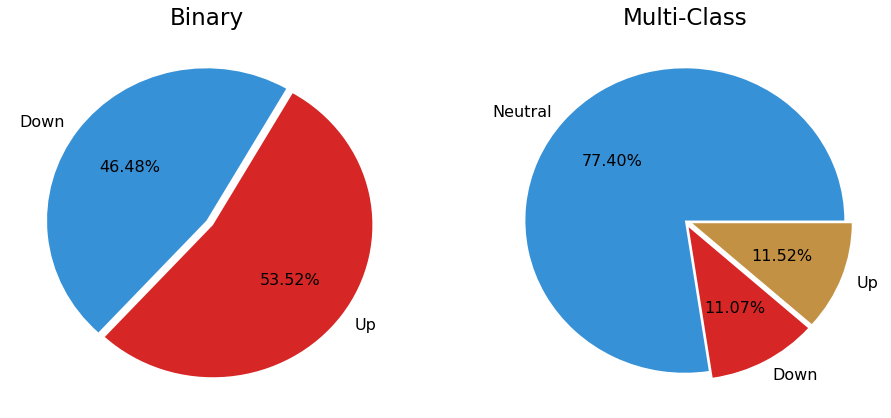

In [472]:
plt.rcParams['font.size'] = 16

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

colors = ["#3791D7", "#D72626", "#C29143"]

pd.Series(Counter(labels)).plot(kind='pie', ax=ax1, title='Binary', labels=['Down', 'Up'],
                               explode=[0,0.05], autopct='%1.2f%%', colors=colors[:-1], startangle=60)
pd.Series(Counter(multi_labels)).plot(kind='pie', ax=ax2, title='Multi-Class', labels=['Neutral', 'Down', 'Up'],
                                     explode=[0,0.05, 0.05], autopct='%1.2f%%', colors=colors)
ax1.set_ylabel('')
ax2.set_ylabel('')
plt.show()

<br>
<br>
# 2. Feature Engineering

## Vectorization 

In [ ]:
def remove_punct(txt):
    
    puncts = set(string.punctuation)
    new_txt = ''.join([char.lower() for char in txt if char not in puncts])
    
    return new_txt
    
def count_vectorizer(txt_train, txt_test, ngram_range=(1,1)):
    cv = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_df=0.99, min_df=3)
    return cv.fit_transform(txt_train), cv.transform(txt_test)
    
def tfidf_vectorizer(txt_train, txt_test, ngram_range=(1,1)):
    ti = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, max_df=0.99, min_df=3)
    return ti.fit_transform(txt_train), ti.transform(txt_test)

def test_split(X, y_1, y_2, test_size=0.2, apply_vectorizer='count', ngram_range=(1,1)):
    n_row = X.shape[0]
    
    rand_index = np.random.permutation(n_row)

    train_index = rand_index[int(n_row*test_size):]
    test_index = rand_index[:int(n_row*test_size)]
    
    X = X.map(remove_punct)
    X_train, X_test = X[train_index], X[test_index]
    y_1_train, y_1_test = y_1[train_index], y_1[test_index]
    y_2_train, y_2_test = y_2[train_index], y_2[test_index]
    
    if apply_vectorizer == 'count':
        X_train, X_test = count_vectorizer(X_train, X_test, ngram_range)
    elif apply_vectorizer == 'tfidf':
        X_train, X_test = tfidf_vectorizer(X_train, X_test, ngram_range)
    
    return (X_train, X_test), (y_1_train, y_1_test), (y_2_train, y_2_test)



In [ ]:
# Counter Vectorization
(X_train, X_test), (bi_y_train, bi_y_test), (mul_y_train, mul_y_test) = \
                                    test_split(headlines, binary_labels, multi_labels)
    
# TF-IDF Vectorization
(X_train, X_test), (bi_y_train, bi_y_test), (mul_y_train, mul_y_test) = \
                                    test_split(headlines, binary_labels, 
                                               multi_labels, apply_vectorizer='tfidf', ngram_range=(1,2))

In [408]:
# TF-IDF Vectorization
(X_train, X_test), (bi_y_train, bi_y_test), (mul_y_train, mul_y_test) = \
                                    test_split(headlines, binary_labels, 
                                               multi_labels, apply_vectorizer='tfidf', ngram_range=(1,1))

## Feature Selection

### Sparicity of Vectors

When learning from high-dimensional data such as text, it has been empirically
observed that relatively few dimensions are relevant to the predictive task. How can we capitalize on this insight and choose which dimensions are relevant
in an informed and principled manner? Sparse regularizers provide a way to select
relevant dimensions by means of regularization. I will first apply plain machine learning algorithms without any feature engineering. Then it will be meaningful to explore sparse regularization techinques.

**Reference**: <a src="https://www.lti.cs.cmu.edu/sites/default/files/dani_yogatama_sparse_models_of_natural_language_text.pdf"> Dani Yogatama, "Sparse Models of Natural Language Text"</a>

In [409]:
# Feature Selection
def features_chi2(features, labels, n_features=5000):
    chi2_model = SelectKBest(chi2, k=n_features)
    new_features = chi2_model.fit_transform(features, labels)
    return new_features, chi2_model

def features_information_gain(features, labels, max_features=1000):
    tree_clf = tree.DecisionTreeClassifier(criterion="entropy", max_features=max_features)
    tree_clf = tree_clf.fit(features, labels)
    inf_gain = SelectFromModel(tree_clf, prefit=True)
    new_features = inf_gain.transform(features)
    return new_features, inf_gain
    
def features_lsa(features,n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    normalizer =  Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    new_features = lsa.fit_transform(features)
    return new_features, lsa

In [410]:
chi2_vec, chi2_model = features_chi2(X_train, bi_y_train, 2000)
ig_vec, ig_model = features_information_gain(X_train, bi_y_train, 2000)
lsa_vec, lsa_model = features_lsa(X_train, 2000)

# 3. Predcitive Modeling

## Binary Classification

In [ ]:
# Initial Modeling
# Stratified Cross-validation
kfold = StratifiedKFold(n_splits=4, random_state=42)

lr = LogisticRegression()
rf = RandomForestClassifier()
svc = LinearSVC()
xgb = XGBClassifier()

# Evaluate
vec_names = ['Chi2', 'IG', "LSA"]
models = [lr, rf, svc, xgb]
model_names = ['Logistic', 'Random Forest', 'Linear SVC', 'XGboosting']

# For future reference
vec_type = []
clf_type = []
metrics = []

# Fit the model
for i, vec in enumerate([chi2_vec, ig_vec, lsa_vec]):
    for model, model_name in zip(models, model_names):
        test_val = cross_validate(model, vec, mul_y_train, scoring=['accuracy', 'precision_weighted', 
                                                       'recall_weighted', 'f1_weighted'], cv=kfold)
        
        accuracy = round(test_val['test_accuracy'].mean(), 3)
        precision = round(test_val['test_precision_weighted'].mean(), 3)
        recall = round(test_val['test_recall_weighted'].mean(), 3)
        fscore = round(test_val['test_f1_weighted'].mean(), 3)
    
        print(vec_names[i], model_name, "- accuracy: {0}, precision: {1}, recall: {2}, fscore: {3}"\
                                  .format(accuracy, precision, recall, fscore))
    
        vec_type.append(vec_names[i])
        clf_type.append(model_name)
        metrics.append([precision, recall, fscore])

## Findings:

- Linear SVC with Chi-squred feature selector achieved a superb performance. (0.905% precision) 

In [452]:
# Linear SVC
param_grid = {'penalty': ['l1', 'l2'],
              'dual': [True, False],
              'C': [0.2, 0.4, 0.6, 0.8, 1.0],
              'multi_class': ['crammer_singer', 'ovr'],
              'class_weight': [None, 'balanced']}
              

clf = LinearSVC()
svc_rs = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, 
                        scoring='f1_weighted', error_score=0)

svc_rs.fit(chi2_vec, bi_y_train)

best_svc = svc_rs.best_estimator_

test_val = cross_validate(best_svc, chi2_vec, mul_y_train, scoring=['precision_weighted', 
                                                       'recall_weighted', 'f1_weighted'], cv=3)

precision = round(test_val['test_precision_weighted'].mean(), 3)
recall = round(test_val['test_recall_weighted'].mean(), 3)
fscore = round(test_val['test_f1_weighted'].mean(), 3)
    
print("chi2 vector -", "SVC", "- precision: {0}, recall: {1}, fscore: {2}".format(precision, recall, fscore))

chi2 vector - SVC - precision: 0.607, recall: 0.778, fscore: 0.682


<br>
## Test Evaluation

In [462]:
pred = RandomForestClassifier().fit(chi2_vec, mul_y_train).predict(chi2_vec_test2)
print(classification_report(mul_y_test, pred))

              precision    recall  f1-score   support

          -1       0.13      0.27      0.18        41
           0       0.76      0.64      0.70       299
           1       0.14      0.16      0.15        57

   micro avg       0.53      0.53      0.53       397
   macro avg       0.35      0.35      0.34       397
weighted avg       0.61      0.53      0.56       397



In [446]:
pred = best_svc.predict(chi2_vec_test2)
print(classification_report(bi_y_test, pred))

              precision    recall  f1-score   support

           0       0.52      0.65      0.57       193
           1       0.56      0.43      0.48       204

   micro avg       0.53      0.53      0.53       397
   macro avg       0.54      0.54      0.53       397
weighted avg       0.54      0.53      0.53       397



In [447]:
chi2_vec_test = chi2_model.transform(X_test)
svm_prob = best_svc.decision_function(chi2_vec_test2)

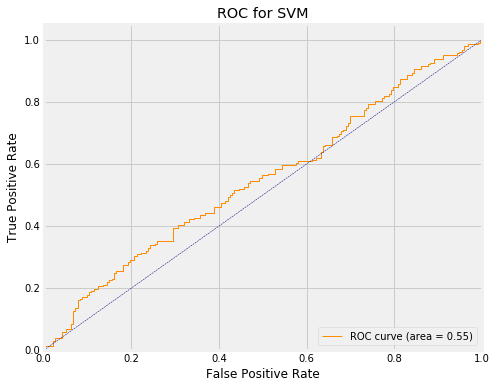

In [448]:
fpr, tpr, thresholds = roc_curve(bi_y_test, svm_prob)

auc_svm = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SVM')
plt.legend(loc="lower right")

In [425]:
svm_prob = best_svc.decision_function(chi2_vec)

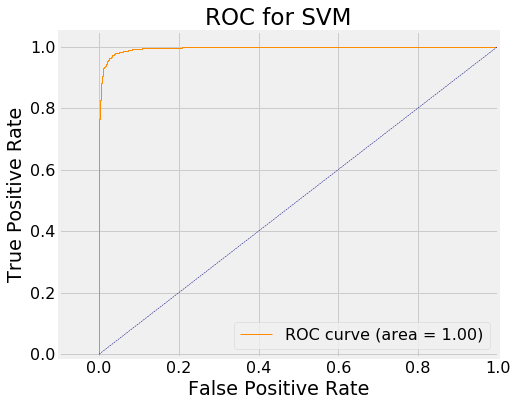

In [426]:
fpr, tpr, thresholds = roc_curve(bi_y_train, svm_prob)

auc_svm = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([-.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SVM')
plt.legend(loc="lower right")

In [240]:
model = Sequential()

model.add(layers.Dense(16, input_shape=[X_train.shape[1]] , activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 16)                2784      
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 16)                64        
_________________________________________________________________
dense_137 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_45 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 16)                64        
_________________________________________________________________
dense_138 (Dense)            (None, 16)                272       
__________

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['acc'])

callbacks = [ModelCheckpoint('best_nn_h5', monitor='val_acc', save_best_only=True)]

history = model.fit(X_train.toarray(), y_train.reshape(-1, 1), batch_size=16, epochs=100,
                    verbose=2, validation_data=(X_test, y_test), callbacks=callbacks)

<br>
# Conclusion:
## This project is still in progress. Will be fully updated in January 2019